In [104]:
from torchvision import datasets, transforms
from torch import utils


transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1))])

dataset_train = datasets.MNIST(
    '~/mnist', 
    train=True, 
    download=True, 
    transform=transform)
dataset_valid = datasets.MNIST(
    '~/mnist', 
    train=False, 
    download=True, 
    transform=transform)

dataloader_train = utils.data.DataLoader(dataset_train,
                                          batch_size=1000,
                                          shuffle=True,
                                          num_workers=4)
dataloader_valid = utils.data.DataLoader(dataset_valid,
                                          batch_size=1000,
                                          shuffle=True,
                                          num_workers=4)

In [138]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = 'cuda'

class VAE(nn.Module):
    def __init__(self, z_dim):
      super(VAE, self).__init__()
      self.dense_enc1 = nn.Linear(28*28, 200)
      self.dense_enc2 = nn.Linear(200, 200)
      self.dense_encmean = nn.Linear(200, z_dim)
      self.dense_encvar = nn.Linear(200, z_dim)
      self.dense_dec1 = nn.Linear(z_dim, 200)
      self.dense_dec2 = nn.Linear(200, 200)
      self.dense_dec3 = nn.Linear(200, 28*28)
    
    def _encoder(self, x):
      x = F.relu(self.dense_enc1(x))
      x = F.relu(self.dense_enc2(x))
      mean = self.dense_encmean(x)
      var = F.softplus(self.dense_encvar(x))
      return mean, var
    
    def _sample_z(self, mean, var):
      epsilon = torch.randn(mean.shape).to(device)
      return mean + torch.sqrt(var) * epsilon
 
    def _decoder(self, z):
      x = F.relu(self.dense_dec1(z))
      x = F.relu(self.dense_dec2(x))
      x = torch.sigmoid(self.dense_dec3(x))
      return x

    def forward(self, x):
      mean, var = self._encoder(x)
      z = self._sample_z(mean, var)
      x = self._decoder(z)
      return x, z
    
    def loss(self, x):
      mean, var = self._encoder(x)
      KL = -0.5 * torch.mean(torch.sum(1 + torch.log(var) - mean**2 - var))
      z = self._sample_z(mean, var)
      y = self._decoder(z)
      reconstruction = torch.mean(torch.sum(x * torch.log(y) + (1 - x) * torch.log(1 - y)))
      lower_bound = [-KL, reconstruction]                                      
      return -sum(lower_bound)

In [165]:
import numpy as np
from torch import optim

model = VAE(10).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()
for i in range(30):
  losses = []
  for x, t in dataloader_train:
      x = x.to(device)
      model.zero_grad()
      y = model(x)
      loss = model.loss(x)
      loss.backward()
      optimizer.step()
      losses.append(loss.cpu().detach().numpy())
  print("EPOCH: {} loss: {}".format(i, np.average(losses)))

EPOCH: 0 loss: 266521.0625
EPOCH: 1 loss: 198689.03125
EPOCH: 2 loss: 186338.390625
EPOCH: 3 loss: 170391.484375
EPOCH: 4 loss: 154486.15625
EPOCH: 5 loss: 145123.203125
EPOCH: 6 loss: 139821.515625
EPOCH: 7 loss: 135810.96875
EPOCH: 8 loss: 132295.703125
EPOCH: 9 loss: 129623.578125
EPOCH: 10 loss: 127539.6328125
EPOCH: 11 loss: 125641.3984375
EPOCH: 12 loss: 123906.609375
EPOCH: 13 loss: 122324.875
EPOCH: 14 loss: 120960.546875
EPOCH: 15 loss: 119855.7421875
EPOCH: 16 loss: 118824.953125
EPOCH: 17 loss: 117834.3203125
EPOCH: 18 loss: 116914.953125
EPOCH: 19 loss: 116108.4296875
EPOCH: 20 loss: 115423.609375
EPOCH: 21 loss: 114918.2421875
EPOCH: 22 loss: 114339.3046875
EPOCH: 23 loss: 113857.734375
EPOCH: 24 loss: 113463.953125
EPOCH: 25 loss: 113041.5
EPOCH: 26 loss: 112690.578125
EPOCH: 27 loss: 112287.5
EPOCH: 28 loss: 111937.3515625
EPOCH: 29 loss: 111633.1015625


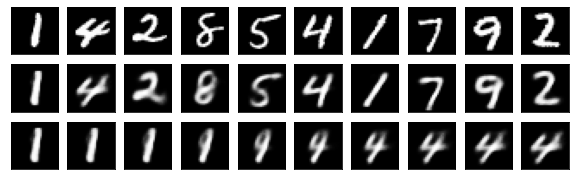

In [166]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10, 3))

model.eval()
zs = []
for x, t in dataloader_valid:
    # original
    for i, im in enumerate(x.view(-1, 28, 28).detach().numpy()[:10]):
      ax = fig.add_subplot(3, 10, i+1, xticks=[], yticks=[])
      ax.imshow(im, 'gray')
    x = x.to(device)
    # generate from x
    y, z = model(x)
    zs.append(z)
    y = y.view(-1, 28, 28)
    for i, im in enumerate(y.cpu().detach().numpy()[:10]):
      ax = fig.add_subplot(3, 10, i+11, xticks=[], yticks=[])
      ax.imshow(im, 'gray')
    # generate from z
    z1to0 = torch.cat([z[1] * (i * 0.1) + z[0] * ((9 - i) * 0.1) for i in range(10)]).view(10, 10)

    y2 = model._decoder(z1to0).view(-1, 28, 28)
    for i, im in enumerate(y2.cpu().detach().numpy()):
      ax = fig.add_subplot(3, 10, i+21, xticks=[], yticks=[])
      ax.imshow(im, 'gray')
    break

In [167]:
# for x, t in dataloader_train:
#   print(x.shape, t.shape)

In [168]:
print(len(dataset_train[0][0]))

784


In [169]:
n_sample = 100
# print(dataset_train[0])
# samples = dataset_train[:n_sample]

# print(samples[0][1])
data0to9 = []

for i in range(10):
  for sample_num in range(n_sample):
    # print(i, dataset_train[sample_num][1])
    if dataset_train[sample_num][1] == i:
      data0to9.append(dataset_train[sample_num][0])
      print(dataset_train[sample_num][1], i)
      break


print(len(data0to9))

0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10


0
torch.Size([784])
1
torch.Size([784])
2
torch.Size([784])
3
torch.Size([784])
4
torch.Size([784])
5
torch.Size([784])
6
torch.Size([784])
7
torch.Size([784])
8
torch.Size([784])
9
torch.Size([784])


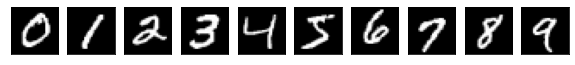

In [179]:
fig = plt.figure(figsize=(10, 3))

model.eval()
for t, x in enumerate(data0to9):
  print(t)
  print(x.shape)
  x = x.view(28, 28).detach().numpy()
  ax = fig.add_subplot(3, 10, t+1, xticks=[], yticks=[])
  ax.imshow(x, 'gray')

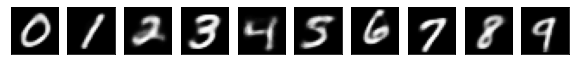

In [187]:
model.eval()
zs = []

fig = plt.figure(figsize=(10, 3))

for t, x in enumerate(data0to9):
  # print(t)
  x = x.to(device)
  y, z = model(x)
  # print(z)
  zs.append(z)
  im_y = y.cpu().detach().numpy().reshape(28, 28)
  # plt.imshow(im, cmap='gray')
  ax = fig.add_subplot(1, 10, t+1, xticks=[], yticks=[])
  ax.imshow(im_y, 'gray')

Type in which number to start with:
3
Type in which number to end with:
7


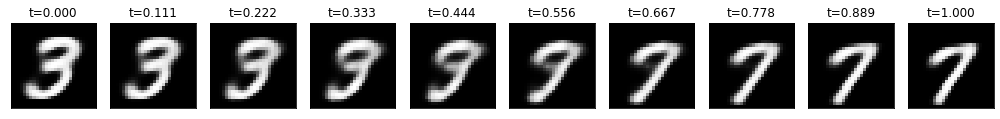

-------------------------------------------------------------------
Type in which number to start with:
0
Type in which number to end with:
4


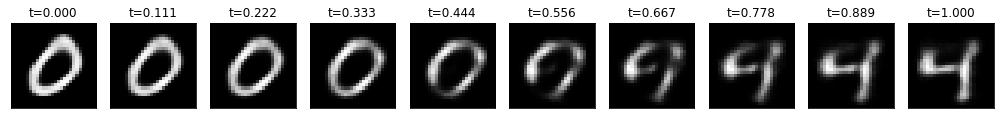

-------------------------------------------------------------------
Type in which number to start with:
1
Type in which number to end with:
8


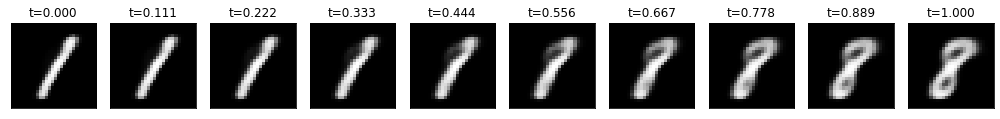

-------------------------------------------------------------------


KeyboardInterrupt: ignored

In [198]:
while True:
  start = input('Type in which number to start with:\n')
  end = input('Type in which number to end with:\n')

  start = int(start)
  end = int(end)

  imgs = []

  plt.figure(figsize=(14,14))

  for i, t in enumerate(np.linspace(0,1,10)):
    # print(i, end=',')
    z_tmp = (1-t) * zs[start] + t * zs[end]
    x_gen = model._decoder(z_tmp.reshape(1, 10))

    plt.subplot(1, 10, i+1)
    im = x_gen.cpu().detach().numpy().reshape(28, 28)
    plt.imshow(im, cmap='gray')
    imgs.append(im)
    plt.xticks([]);plt.yticks([])
    plt.title('t={0:.3f}'.format(t))
  plt.tight_layout()
  plt.show()
  print('-------------------------------------------------------------------')

In [188]:
# model.eval()
# zs = []

# for t, x in enumerate(data0to9):
#   print(t)
#   x = x.to(device)
#   y, z = model(x)
#   zs.append(z)
#   y = y.view(-1, 28, 28)
#   y.cpu().detach().numpy()[:10]
#   ay = fig.add_subplot(3, 10, t+1, xticks=[], yticks=[])
#   ay.imshow(im, 'gray')

  # for i, im in enumerate(y.cpu().detach().numpy()[:10]):
  #     ax = fig.add_subplot(3, 10, t+1, xticks=[], yticks=[])
  #     ax.imshow(im, 'gray')


    # for i, im in enumerate(x.view(-1, 28, 28).detach().numpy()[:10]):
    #   ax = fig.add_subplot(3, 10, i+1, xticks=[], yticks=[])
    #   ax.imshow(im, 'gray')
    # x = x.to(device)
    # # generate from x
    # y, z = model(x)
    # zs.append(z)
    # y = y.view(-1, 28, 28)
    # for i, im in enumerate(y.cpu().detach().numpy()[:10]):
    #   ax = fig.add_subplot(3, 10, i+11, xticks=[], yticks=[])
    #   ax.imshow(im, 'gray')
    # # generate from z
    # # z1to0 = torch.cat([z[1] * (i * 0.1) + z[0] * ((9 - i) * 0.1) for i in range(10)]).view(10, 10)

    # y2 = model._decoder(z1to0).view(-1, 28, 28)
    # for i, im in enumerate(y2.cpu().detach().numpy()):
    #   ax = fig.add_subplot(3, 10, i+21, xticks=[], yticks=[])
    #   ax.imshow(im, 'gray')
    # break